# A Pairs Trading strategy boosted with AI

This notebook explores a pairs trading strategy fueled by AI innovative techniques. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

# just set the seed for the random number generator
np.random.seed(107)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ts = TimeSeries(key='MM44549W9ALMWMU0', output_format='pandas')

### Import Classes

In [3]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader
%autoreload 1

In [4]:
series_analyzer = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()

In [5]:
def read_pair(leg1, leg2, data_source, initial_date, final_date, close_type='Adj Close'):
    
    leg1_df = data.DataReader(leg1, data_source, initial_date, final_date)
    leg2_df = data.DataReader(leg2, data_source, initial_date, final_date)
    
    # filter columns of interest
    leg1_name = leg1 + "_close"
    leg2_name = leg2 + "_close"
    leg1_df = leg1_df[[close_type]].rename(columns={close_type: leg1_name})
    leg2_df = leg2_df[[close_type]].rename(columns={close_type: leg2_name})
    
    # concat in df
    pair_df = pd.concat([leg1_df, leg2_df], axis=1)
    
    # plot
    pair_df.plot(figsize=(20, 10), use_index=True, grid=True);
    
    return pair_df

# 3. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

In [6]:
etfs = pd.read_excel('data/etfs/commodity_ETFs.xlsx')

In [7]:
duplicated_etfs = etfs[etfs.duplicated(subset=['Ticker'], keep=False)].sort_values(['Ticker'])
duplicated_etfs

,Sector,Ticker,Description,Issuer,AUM,ExpenseRatio,3-MO TR,Segment
59,Commodity,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
339,Precious Metals,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
232,Gold,AAAU,Perth Mint Physical Gold ETF,Exchange Traded Concepts,$108.72M,0.18%,4.10%,Commodities: Precious Metals Gold
137,Commodity,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
17,Agriculture,AGF,DB Agriculture Long ETN,Deutsche Bank,$716.83K,0.75%,NaN,Commodities: Agriculture
48,Commodity,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
362,Silver,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
334,Precious Metals,AGQ,ProShares Ultra Silver,ProShares,$183.61M,5.28%,7.49%,Leveraged Commodities: Precious Metals Silver
102,Commodity,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton
152,Cotton,BAL,iPath Series B Bloomberg Cotton Subindex Total...,Barclays Bank PLC,$8.84M,0.45%,5.30%,Commodities: Agriculture Cotton


Remove duplicates

In [8]:
etfs_unique = etfs[~etfs.duplicated(subset=['Ticker'], keep='first')].sort_values(['Ticker'])

In [9]:
tickers = etfs_unique.Ticker.unique()

In [10]:
initial_date = '01-01-2016'
final_date = '01-01-2017'
data_source = 'yahoo'
error_counter = 0
dataset = {key: None for key in tickers}
for ticker in tickers:
    try:
        df = data.DataReader(ticker, data_source, initial_date, final_date)
        df = df[['Adj Close']].rename(columns={'Adj Close':ticker}) # filter close price only
        dataset[ticker] = df.copy()
    except:
        error_counter = error_counter + 1
        print('Not Possible to retrieve information for '+ticker)

Not Possible to retrieve information for AAAU
Not Possible to retrieve information for AOIL
Not Possible to retrieve information for BAR
Not Possible to retrieve information for BATT
Not Possible to retrieve information for BCD
Not Possible to retrieve information for BCI
Not Possible to retrieve information for BMLP
Not Possible to retrieve information for CMDY
Not Possible to retrieve information for COMG
Not Possible to retrieve information for GLDM
Not Possible to retrieve information for GLDW
Not Possible to retrieve information for GOAU
Not Possible to retrieve information for IAUF
Not Possible to retrieve information for MLPO
Not Possible to retrieve information for PLTM
Not Possible to retrieve information for PPLN
Not Possible to retrieve information for PYPE
Not Possible to retrieve information for SDCI
Not Possible to retrieve information for TBLU
Not Possible to retrieve information for USAI
Not Possible to retrieve information for USOD
Not Possible to retrieve information 

In [11]:
print('Unable to download ' + str(error_counter/len(tickers)*100) + '% of the ETFs')
print('From now on, we are only considering ' + str(len(tickers)-error_counter) + ' ETFs')

Unable to download 11.981566820276496% of the ETFs
From now on, we are only considering 191 ETFs


## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

In [12]:
first_count = True
for k in dataset.keys():
    if dataset[k] is not None:
        if first_count:
            etfs_pricing = dataset[k]
            first_count = False
        else:
            etfs_pricing = pd.concat([etfs_pricing, dataset[k]], axis=1)
            
print(etfs_pricing.shape)

(252, 191)


**Remove ETFs without sufficient information**

In [13]:
null_values = etfs_pricing.isnull().sum()
null_values = null_values[null_values > 0]
null_values

AMJL     94
COMB    249
DWT     237
FTXN    183
GDXX     26
JHME     59
MLPE    153
MLPQ     26
MLPZ     31
OILD    205
OILK    186
OILU    205
OILX     31
UWT     237
dtype: int64

In [14]:
threshold = 0
to_remove = list(null_values[null_values>threshold].index)
etfs_pricing = etfs_pricing.drop(columns=to_remove)
print(etfs_pricing.shape)

(252, 177)


In [15]:
etfs_returns = etfs_pricing.pct_change()
etfs_returns = etfs_returns.iloc[1:]
etfs_returns.head()

,AGF,AGQ,AMJ,AMLP,AMU,AMUB,AMZA,ATMP,BAL,BCM,...,VDE,WEAT,XES,XLE,XME,XOP,YMLI,YMLP,ZMLP,ZSL
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.000000,0.018785,-0.004429,-0.006579,-0.003773,0.000000,-0.000092,0.001568,0.000240,-0.016380,...,0.003610,-0.001117,-0.029742,0.003814,0.002670,-0.003293,-0.002371,-0.006397,-0.002292,-0.017007
2016-01-06,0.000000,0.004700,-0.049281,-0.057119,-0.051948,0.000000,-0.079032,-0.053758,-0.010812,-0.013664,...,-0.038844,0.005593,-0.056680,-0.038493,-0.017976,-0.068715,-0.053883,-0.045064,-0.047099,-0.003968
2016-01-07,-0.026364,0.042461,-0.049316,-0.053556,-0.047945,0.046325,-0.068931,-0.049642,-0.011902,-0.003896,...,-0.024947,0.010011,-0.037400,-0.024399,-0.035932,-0.024832,-0.060302,-0.047191,-0.039180,-0.040000
2016-01-08,0.000000,-0.049361,0.011738,0.019480,0.009592,0.000000,0.000000,0.011608,-0.000246,-0.002173,...,-0.012665,0.016520,-0.019108,-0.012857,-0.026723,0.004729,0.031194,0.030660,0.018821,0.044821
2016-01-11,0.000000,-0.009441,-0.051647,-0.053685,-0.052850,0.000000,-0.074034,-0.052209,0.000492,-0.021777,...,-0.022674,-0.017335,-0.032467,-0.021409,-0.059248,-0.039102,-0.067416,-0.041190,-0.048030,0.016365


In [16]:
print('Total number of possible pairs: ', len(etfs_returns.columns)*(len(etfs_returns.columns)-1)/2)

Total number of possible pairs:  15576.0


**Applying PCA on Returns**

In [17]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(etfs_returns)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
pca.components_.T.shape

(177, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. 

In [19]:
X = preprocessing.StandardScaler().fit_transform(pca.components_.T)
print(X.shape)

(177, 50)


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [20]:
clf = DBSCAN(eps=2, min_samples=2)
print(clf)

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("\nClusters discovered: %d" % n_clusters_)

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=2, n_jobs=1, p=None)

Clusters discovered: 11


In [21]:
clustered_series = pd.Series(index=etfs_returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [22]:
counts = clustered_series.value_counts()
print("Clusters formed: %d" % len(counts))
print("Pairs to evaluate: %d" % (counts*(counts-1)/2).sum())

Clusters formed: 11
Pairs to evaluate: 153


In [23]:
print(counts)

1     14
3      8
0      6
5      5
10     3
9      2
8      2
7      2
6      2
4      2
2      2
dtype: int64


**Fundamental analysis for clusters**

In [24]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))
    #print('\nCluster {}:\n{}'.format(label_n,etfs_cluster_n.Segment.value_counts()))


Cluster 0:
    Ticker            Segment
156    AMJ  Equity: U.S. MLPs
154   AMLP  Equity: U.S. MLPs
170    AMU  Equity: U.S. MLPs
189   IMLP  Equity: U.S. MLPs
161   MLPA  Equity: U.S. MLPs
159   MLPI  Equity: U.S. MLPs

Cluster 1:
    Ticker                        Segment
72     BCM      Commodities: Broad Market
28     DBC      Commodities: Broad Market
61     DBE            Commodities: Energy
78    DJCI      Commodities: Broad Market
32     DJP      Commodities: Broad Market
50    FTGC      Commodities: Broad Market
53     GCC      Commodities: Broad Market
30     GSG      Commodities: Broad Market
79     GSP      Commodities: Broad Market
27    PDBC      Commodities: Broad Market
145    RJI      Commodities: Broad Market
67     UCI      Commodities: Broad Market
37    USCI      Commodities: Broad Market
68     USL  Commodities: Energy Crude Oil

Cluster 2:
    Ticker               Segment
378    CGW  Equity: Global Water
380    PIO  Equity: Global Water

Cluster 3:
   Ticker    

Comparing results obtaned with most obvious scenario:

In [25]:
grouped = etfs_unique.groupby(by='Segment').count()[['Ticker']]
grouped[grouped.Ticker > 1]

,Ticker
Segment,
Commodities: Agriculture,7
Commodities: Agriculture Grains,3
Commodities: Agriculture Sugar,2
Commodities: Broad Market,21
Commodities: Energy,4
Commodities: Energy Crude Oil,10
Commodities: Energy Natural Gas,3
Commodities: Industrial Metals,2
Commodities: Industrial Metals Copper,2


What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

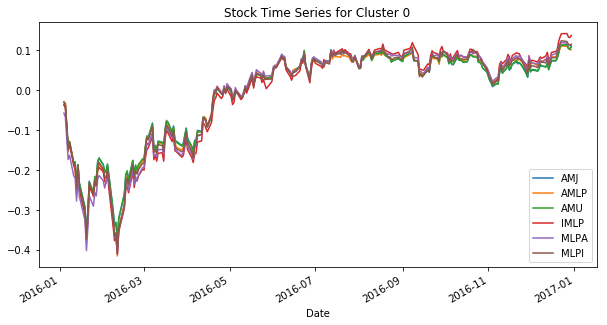

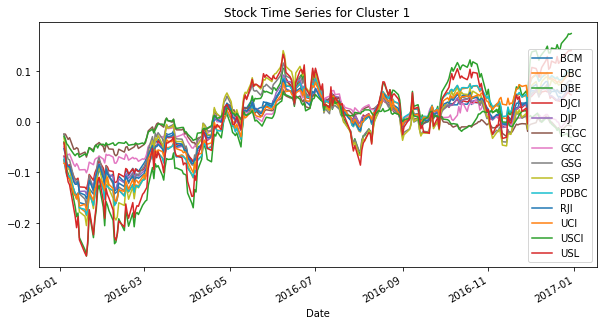

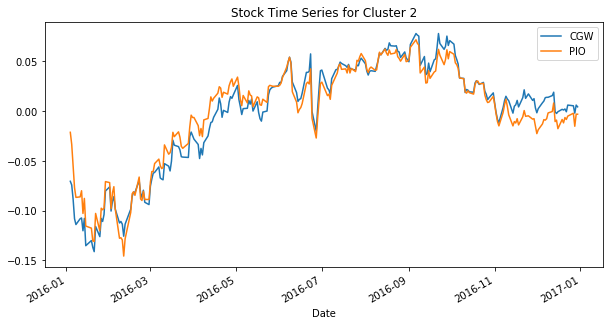

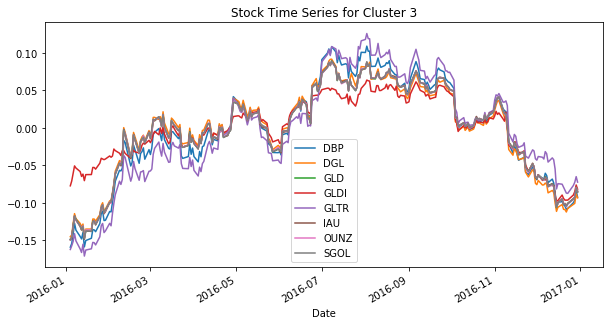

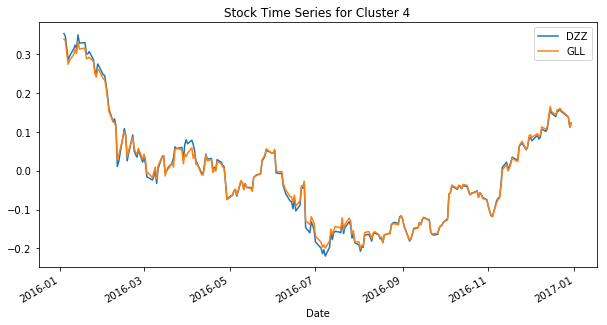

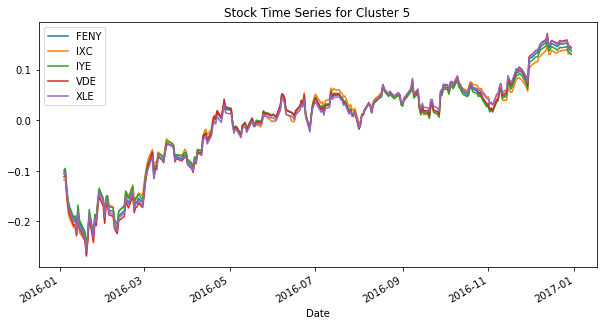

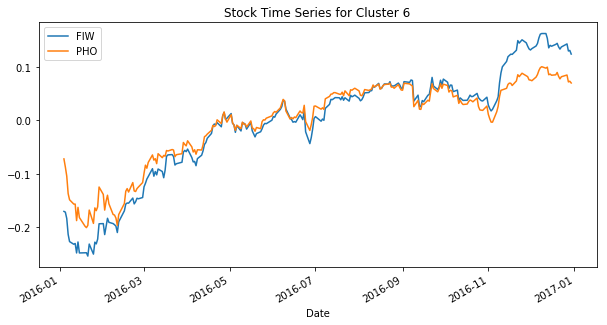

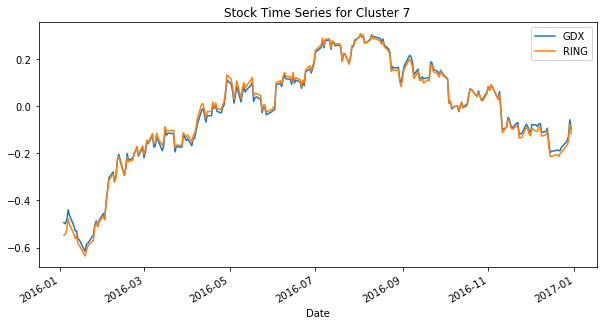

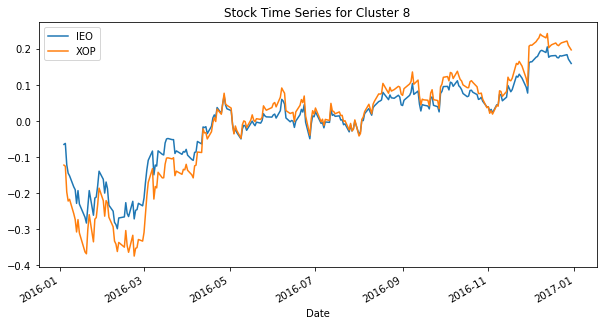

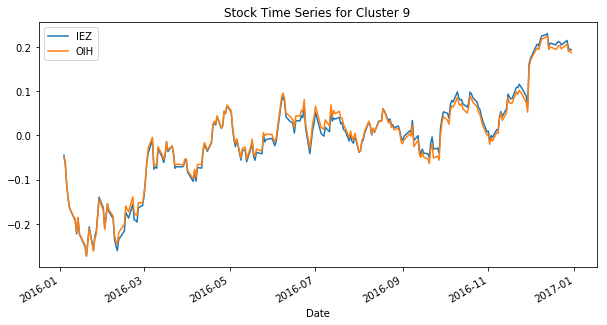

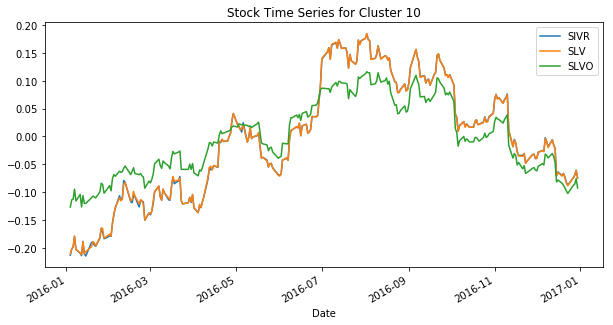

In [26]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(etfs_pricing[symbols].mean())
    series = np.log(etfs_pricing[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [33]:
total_pairs = []
threshold = 0.05
pairs_found = 0
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    cluster_pricing = etfs_pricing[symbols]
    pairs = series_analyzer.find_cointegrated_pairs(cluster_pricing, threshold, 5)
    total_pairs.extend(pairs)
    #print('\nCluster {}: {}'.format(clust,[(pair[0], pair[1], pair[2]['p_value']) for pair in pairs]))
    pairs_found += len(pairs)
print('Found {} pairs'.format(pairs_found))

Found 34 pairs


In [34]:
print('The pairs contain {} unique tickers'.format(
        len(np.unique([(element[0], element[1]) for element in total_pairs]))))

The pairs contain 32 unique tickers


**Applying Bollinger Bands**

In [35]:
lookback_multiplier=2
sharpe_results_bollinger = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    #print('Cointegration coefficient: ',coint_result['coint_coef'])
    hl = series_analyzer.calculate_half_life(coint_result['spread'])
    pnl, ret, summary, sharpe = trader.bollinger_band_strategy(coint_result['Y'], coint_result['X'], 
                                                               lookback_multiplier*int(round(hl)))
    sharpe_results_bollinger.append(sharpe)



BCM,GSG
APR 0.025962816165044478
Sharpe 0.8016803717109295


BCM,GSP
APR 0.03390440662867178
Sharpe 0.9020681117473213


BCM,USL
APR -0.021623893205089617
Sharpe -0.4091367999356178


DBC,DBE
APR 0.006832865086656259
Sharpe 0.24808609578245322


DBC,USL
APR 0.030884372040330454
Sharpe 0.8021557908156535


DBE,DJCI
APR -0.0846471127013132
Sharpe -2.0447919357473743


DBE,PDBC
APR 0.03377424930827422
Sharpe 1.0436313235604324


DBE,UCI
APR -0.0009031665936698463
Sharpe 0.022255505495122358


DJCI,GSG
APR -0.02612908269809522
Sharpe -0.748936843583721


DJCI,GSP
APR -0.04994331593979329
Sharpe -1.3288392127384623


DJCI,USL
APR -0.024032077127974505
Sharpe -0.4245354143287653


DJP,GSG
APR -0.015476782884673579
Sharpe -0.46870010370308257


DJP,GSP
APR -0.043165451707251945
Sharpe -1.3108650554099956


DJP,USL
APR 0.04318817394859509
Sharpe 0.8924151244567191


FTGC,USCI
APR 0.02394049569211254
Sharpe 0.8473436677284341


GCC,USCI
APR -0.02894693028155837
Sharpe -0.8751514082757381


PD

**Bollinger Bands Performance**

Sharpe Ratio Results: 
Average result:  -0.2681531872593481


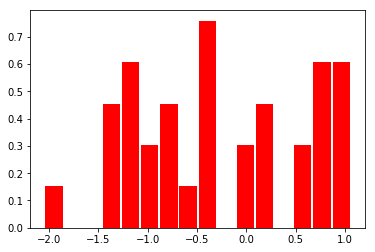

In [36]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_bollinger, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_bollinger))

**Applying the Kalman filter based strategy**

In [31]:
sharpe_results_kalman = []
for pair in total_pairs:
    print('\n\n{},{}'.format(pair[0], pair[1]))
    coint_result = pair[2]
    pnl, ret, sharpe = trader.kalman_filter(y=coint_result['Y'], x=coint_result['X'])
    sharpe_results_kalman.append(sharpe)



BCM,GSG
APR 0.067072738012115
Sharpe 1.6403658881829304


BCM,GSP
APR 0.0909619984892045
Sharpe 1.4110697826502205


BCM,USL
APR 0.0743191200914961
Sharpe 0.8309764597744863


DBC,DBE
APR 0.013794972498879288
Sharpe 0.28341449828597504


DBC,USL
APR 0.06473317836381587
Sharpe 0.8782701170165386


DBE,PDBC
APR 0.019514027433101155
Sharpe 0.39388459188425784


DBE,UCI
APR 0.011847564881425798
Sharpe 0.22225461133563493


DJCI,GSP
APR 0.027198030611382817
Sharpe 0.590342136294552


DJCI,USL
APR 0.06796112602408111
Sharpe 0.8422871193894174


DJP,GSG
APR 0.028087388998592866
Sharpe 1.7503307847023144


DJP,GSP
APR 0.027889473650424934
Sharpe 1.115358870568886


DJP,USL
APR 0.050981056527978685
Sharpe 0.6017017911011133


GCC,USCI
APR 0.023973959781547594
Sharpe 0.9323725316828667


PDBC,USL
APR 0.024630177670144304
Sharpe 0.3819866365080265


RJI,USL
APR 0.07513199644532143
Sharpe 0.8074460806754553


UCI,USL
APR 0.09966048870367539
Sharpe 1.1309801632295156


CGW,PIO
APR -0.003212886132

**Kalman Filter Performance**

Sharpe Ratio Results: 
Average result:  0.7920905334381435


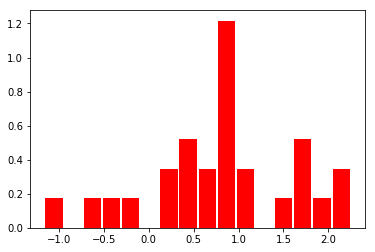

In [32]:
print('Sharpe Ratio Results: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')
print('Average result: ', np.mean(sharpe_results_kalman))